In [89]:
# importing the required libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [90]:
# Loading the data using the Pandas Datareader
stock = input("Enter name of Stock:\n") #name of stock

begin = dt.datetime(2010,1,1) #start point of the data
end = dt.datetime(2018,1,1) #end point of the data

input_data = web.DataReader(stock, 'yahoo', begin, end) #getting data from the yahoo finance API

In [88]:
# Preparing data for the neural network
scaler = MinMaxScaler(feature_range=(0,1)) #scaling down the data between 0 and 1
scaled_data = scaler.fit_transform(input_data['Close'].values.reshape(-1,1)) #transforming the dataset based on closing price of the market
duration = 60 #number of days to look back at for prediction

#empty lists to prepare training data
x_train = []
y_train = []

#starts counting from the 60th index down to the last index
for i in range(duration,len(scaled_data)):
    #adding scaled data value to x_train with each iteration
    #appends 60 values and then the 61st value so model learns to predict
    x_train.append(scaled_data[i - duration:i,0])
    # 61 data value
    y_train.append(scaled_data[i ,0])

#converting to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#reshaping array to work with neural network
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [83]:
# Building the Model

#creating a neural network
model = Sequential()

#Creating the NN layers
#Adding a regularization method (dropout layer) after every LSTM layer 
# to probabilistically exclude input and recurrent connections.
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1))) #Layer 1
model.add(Dropout(0.2)) 
model.add(LSTM(units=50, return_sequences=True)) #Layer 2
model.add(Dropout(0.2))
model.add(LSTM(units=50)) #Layer 3
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Changing the dimensionality to desired target

#Optimizer for the Keras Model
model.compile(optimizer='adam', loss='mean_squared_error')
#Fit the model on the training data
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
62/62 [==============================] - 8s 42ms/step - loss: 0.0219
Epoch 2/25
62/62 [==============================] - 3s 42ms/step - loss: 0.0035
Epoch 3/25
62/62 [==============================] - 3s 42ms/step - loss: 0.0030
Epoch 4/25
62/62 [==============================] - 3s 49ms/step - loss: 0.0028
Epoch 5/25
62/62 [==============================] - 3s 56ms/step - loss: 0.0027
Epoch 6/25
62/62 [==============================] - 3s 45ms/step - loss: 0.0026
Epoch 7/25
62/62 [==============================] - 3s 43ms/step - loss: 0.0025
Epoch 8/25
62/62 [==============================] - 2s 38ms/step - loss: 0.0024
Epoch 9/25
62/62 [==============================] - 3s 45ms/step - loss: 0.0029
Epoch 10/25
62/62 [==============================] - 3s 49ms/step - loss: 0.0025
Epoch 11/25
62/62 [==============================] - 2s 40ms/step - loss: 0.0021
Epoch 12/25
62/62 [==============================] - 2s 39ms/step - loss: 0.0020
Epoch 13/25
62/62 [==================

In [84]:
#Preparing test data to test model accuracy on existing data

#New input data for the model
new_start = dt.datetime(2018,1,1)
new_end = dt.datetime.now()
new_data = web.DataReader(stock, 'yahoo', new_start, new_end)
actual_prices = new_data['Close'].values

#combining closing value of training and testing data
combined_dataset = pd.concat((input_data['Close'], new_data['Close']), axis=0)

model_inputs = combined_dataset[len(combined_dataset) - len(new_data) - duration:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [85]:
#Evaluating the accuracy of the model on the test data

#Repeating data append like above
x_test = []
for x in range(duration, len(model_inputs)):
    x_test.append(model_inputs[x-duration:x,0])

x_test = np.array(x_test) #converting to np array
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1)) #reshaping to fit the model

prediction = model.predict(x_test) #the predicted prices
prediction = scaler.inverse_transform(prediction) #inversing the transformation

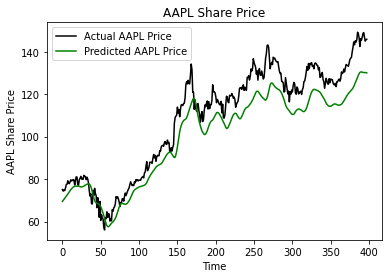

In [74]:
#plot
plt.plot(actual_prices, color = "red", label = f"Actual {stock} Price")
plt.plot(prediction, color = "green", label = f"Predicted {stock} Price")
plt.title(f"{stock} Share Price")
plt.xlabel('Time')
plt.ylabel(f'Share Price (USD)')
plt.legend()
plt.show()